# Import

In [1]:
import cv2
import numpy as np
#import csv
import glob
import os
import torch


from skimage import measure
from scipy import ndimage
from tqdm import tqdm
from PIL import Image,ImageOps
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# Config
Attention: 
* Depending on the height of the camera when recording, the min/max number of pixels must be adjusted.
* If another plug is used, the default_ratio must be adjusted.


In [3]:
path = 'dataset/mini_testdatensatz'
path = path + '/'
device = "cuda"
default_ratio = 3.5
min_pixel = 5000 # für höhe 100 sehr guter wert: 12000
max_pixel = 10000 # für höhe 100 sehr guter wert: 24000

# Init model

In [ ]:
sam = sam_model_registry["default"](checkpoint="sam_model/sam_vit_h_4b8939.pth")
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Folder for Segementation

Attention: This functions delets all segmentation images in the path, if the path contains them

In [ ]:
if not os.path.exists(os.path.join(path,'segmentation_images')):
    os.mkdir(os.path.join(path,'segmentation_images'))

filelist = [ f for f in os.listdir(os.path.join(path,'segmentation_images'))]
for f in filelist:
    os.remove(os.path.join(path,'segmentation_images', f))

# Define Functions for the loop

In [ ]:
def find_biggest_contiguous_area(array):
    labels,_ = ndimage.label(array)
    counts = np.bincount(labels.flatten())
    max_label = np.argmax(counts[1:]) + 1
    region = (labels == max_label)
    
    return region

# List with all image paths

In [ ]:
img_path_list = sorted(glob.glob(path+'/train/*')) # normaly glob.glob(path+'/train/*')

# Sam Segmentation Loop

In [ ]:
for img_path in tqdm(img_path_list):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ratio_with_mask = [[],[]]

    for mask in sorted_masks:
        if mask['area'] > min_pixel and mask['area'] < max_pixel:
            maybe_plugmask = find_biggest_contiguous_area(mask['segmentation'])
            maybe_plugmask = np.array(maybe_plugmask, dtype=np.uint8)
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(maybe_plugmask)
            bbox = stats[1][:4]
            x,y,w,h = bbox
            ratio_with_mask[0].append(w/h)
            ratio_with_mask[1].append(maybe_plugmask)

    closest_value = min(ratio_with_mask[0], key=lambda x: abs(x - default_ratio))
    closest_index = ratio_with_mask[0].index(closest_value)
    plug_mask = ratio_with_mask[1][closest_index]

    plug_image = Image.fromarray(plug_mask.astype('uint8') * 255, mode='L')
    img_name = img_path.split('/')[-1]
    plug_image.save(path+'/segmentation_images/'+img_name)

# test singel images with different sizes

In [5]:
im_size =[720,720] # [height, width]
number = 100 # number of image to show

mask_path = path+'/segmentation_images/picture_'+str(number)+'.png'
img_path = path+'/train/picture_'+str(number)+'.png'

Wichtige Info: img_patch und img_segmentation2 sind die gleichen Funktionen wie in train_dataset.py --> wurden hier nur als einzelne Funktionen definiert, da diese in train_dataset.py teil einer Klasse sind.

In [6]:
def img_patch(img,segmentation=False):
        # Calculate the aspect ratio of the image
        img_ratio = img.width / img.height

        # If the image is wider than it is high
        if img_ratio > 1:
            # Scale the width to the desired size and calculate the height while maintaining the aspect ratio
            new_width = im_size[0]
            new_height = int(new_width / img_ratio)
        # If the image is taller than it is wide
        else:
            # Scale the height to the desired size and calculate the width while maintaining the aspect ratio
            new_height = im_size[1]
            new_width = int(new_height * img_ratio)

        # Resize the image to the calculated size while maintaining the aspect ratio
        img = img.resize((new_width, new_height), resample=Image.BICUBIC)

        # Add black borders to the left and right or top and bottom of the image to make it the desired size
        delta_w = im_size[0] - new_width
        delta_h = im_size[1] - new_height
        pad_width = delta_w // 2
        pad_height = delta_h // 2
        padding = (pad_width, pad_height, delta_w - pad_width, delta_h - pad_height)
        if segmentation:
            img = ImageOps.expand(img, border=padding, fill=(0))
        else:
            img = ImageOps.expand(img, border=padding, fill=(255,255,255))

        # Return the scaled and centered image
        return img

In [7]:
def img_segmention2(mask_path):

    mask = Image.open(mask_path).convert('1')
    mask = img_patch(mask,segmentation=True) # problem with the color --> we only need one channel
    mask = np.array(mask)
    mask_tensor = torch.from_numpy(mask)

    return mask_tensor, mask

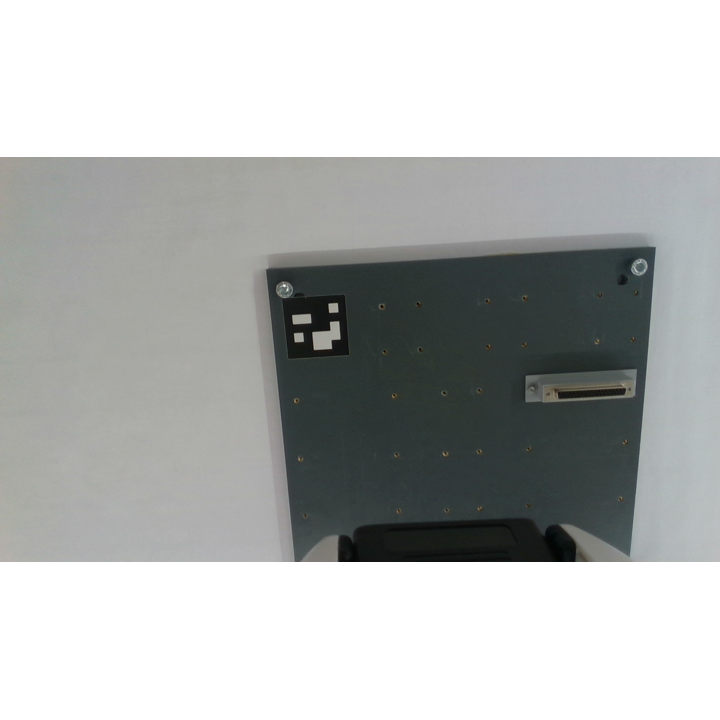

In [8]:
img = Image.open(img_path)
img = img_patch(img)
img = np.array(img)
display(Image.fromarray(img))


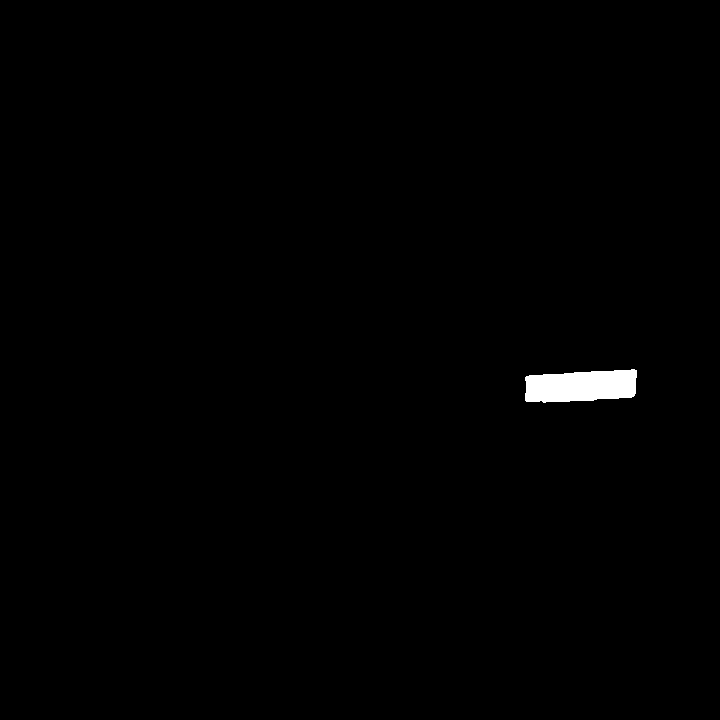

In [9]:
_,mask = img_segmention2(mask_path)
display(Image.fromarray(mask))

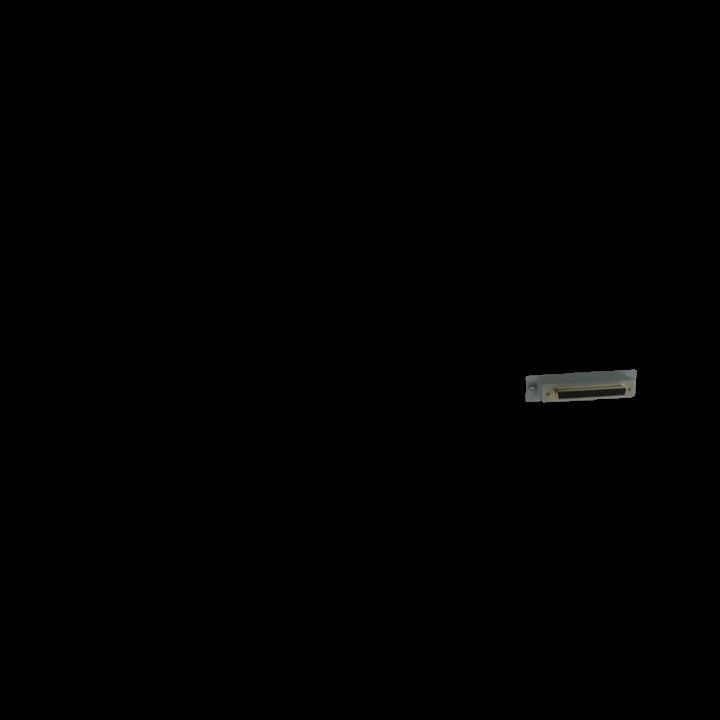

In [10]:
result_array = np.zeros_like(img)
result_array[mask] = img[mask]
result_image = Image.fromarray(result_array)
display(result_image)